# Analysis of Online News Popularity

**Created by Phillip Efthimion, Scott Payne, Gino Varghese and John Blevins**

*MSDS 7331 Data Mining - Section 403 - Lab 2*

## Data Preparation Part 1	
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

Phillip
* Copy data preparation steps
* Copy Dimension Reduction and Scaling from Minilab (PCA)- this pickup up in Modeling and Evaluation 2

## Data Preparation Part 2
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

Phillip
* Describe how we created Popularity
* Insert chart with attributes and meaning from lab 1

### including data points for evaluation section

In [8]:
# Import and Configure Required Modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import datetime
warnings.simplefilter('ignore', DeprecationWarning)
plt.rcParams['figure.figsize']=(15,10)

# Read Online News Data
df = pd.read_csv('data/OnlineNewsPopularity.csv')

# Correct Column Names by Removing Leading Space
df.columns = df.columns.str.replace(' ', '')

# Rename Columns for Ease of Display
df = df.rename(columns={'weekday_is_monday': 'monday', 'weekday_is_tuesday': 'tuesday', 'weekday_is_wednesday': 'wednesday', 'weekday_is_thursday': 'thursday', 'weekday_is_friday': 'friday', 'weekday_is_saturday': 'saturday', 'weekday_is_sunday': 'sunday', 'is_weekend': 'weekend'})
df = df.rename(columns={'data_channel_is_lifestyle':'lifestyle', 'data_channel_is_entertainment':'entertainment', 'data_channel_is_bus':'business', 'data_channel_is_socmed':'social_media', 'data_channel_is_tech':'technology', 'data_channel_is_world':'world'})

# Encode a new "popular" column based on the # of shares 
# "popular" = 1 and "not popular" to 0.
df['popularity'] = pd.qcut(df['shares'].values, 2, labels=[0,1])
df.popularity = df.popularity.astype(np.int)

# Take a subset of the data related to Technology News Articles
dfsubset = df.loc[df['technology'] == 1]

# Reassign to New Variable and remove Columns which aren't needed
df_imputed = dfsubset
del df_imputed['url']
#del df_imputed['shares']
del df_imputed['timedelta']
del df_imputed['lifestyle']
del df_imputed['entertainment']
del df_imputed['business']
del df_imputed['social_media']
del df_imputed['technology']
del df_imputed['world']

# Display Dataframe Structure
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7346 entries, 4 to 39639
Data columns (total 54 columns):
n_tokens_title                  7346 non-null float64
n_tokens_content                7346 non-null float64
n_unique_tokens                 7346 non-null float64
n_non_stop_words                7346 non-null float64
n_non_stop_unique_tokens        7346 non-null float64
num_hrefs                       7346 non-null float64
num_self_hrefs                  7346 non-null float64
num_imgs                        7346 non-null float64
num_videos                      7346 non-null float64
average_token_length            7346 non-null float64
num_keywords                    7346 non-null float64
kw_min_min                      7346 non-null float64
kw_max_min                      7346 non-null float64
kw_avg_min                      7346 non-null float64
kw_min_max                      7346 non-null float64
kw_max_max                      7346 non-null float64
kw_avg_max                  

## Modeling and Evaluation 1
Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

Phillip
* Calculating Acc, Rec, F-measure, Negative Predictive Value, Specificity etc... from confusion matrix

Gino - Saturday Afternoon

Final attributes from PCA:
['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']

* 2 Tasks: Popularity (classification) and Share # (Regression)
* Regression - Linear, Lasso, Ridge
* Classification - Logistic Regression, K nearest Neighbors, Random Forest

In [9]:
#import metrics to collect metrics for each modelS
from sklearn import metrics as mt

#Separating data sets for each task

#task 1 Popularity Classification
df_task1 = df_imputed[['popularity','n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']].copy()


#task 2 Shares Regression
df_task2 = df_imputed
df_task2 = df_task2.drop(['popularity'],axis=1)


#Create list to store datapoints for accuracy, precision, recall, F-measure from each of the model
accuracy_dp = []
precision_dp = []
recall_dp = []
fmeasure_dp = []


## Modeling and Evaluation 2
Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

Gino


In [10]:
#stratified 10 folds
from sklearn.model_selection import StratifiedKFold

# we want to predict the X and y data as follows:
if 'popularity' in df_task1:
    y = df_task1['popularity'].values # get the labels we want
    del df_task1['popularity'] # get rid of the class label
    X = df_task1.values # use everything else to predict!
    

yhat = np.zeros(y.shape)

cv_object = StratifiedKFold(n_splits=10, random_state=True, shuffle=True)
                         
print(cv_object)
cv_object.get_n_splits(X,y)

StratifiedKFold(n_splits=10, random_state=True, shuffle=True)


10

## Modeling and Evaluation 3
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

Gino

* For Regression make sure popularity field is excluded and for classification make sure Share # is excluded!

## Task 1 : Popularity (classification) 

#### Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

# get a handle to the classifier object, which defines the type
#penalty is set to default, which is 12.
lr_task1 = LogisticRegression(C=1.0, class_weight=None)

# iterate through and get predictions for each row in yhat
for train, test in cv_object.split(X,y):
    lr_task1.fit(X[train],y[train])
    yhat[test] = lr_task1.predict(X[test])

#evaluation metrics   
acc = mt.accuracy_score(y, yhat)
recall = mt.recall_score(y, yhat)
precision = mt.precision_score(y, yhat)
f = mt.f1_score(y, yhat)


#adding evaluation metrics to list for further analysis between models
accuracy_dp.append(acc)
recall_dp.append(recall)
precision_dp.append(precision)
fmeasure_dp.append(f)



#results in percentage
print("Accuracy of the model: {0:.4f}%".format(acc*100))
print("Recall of the model: {0:.4f}%".format(recall*100))
print("Precision of the model: {0:.4f}%".format(precision*100))
print("F-measure of the model: {0:.4f}%".format(f*100))


Accuracy of the model: 62.6736%
Recall of the model: 86.4648%
Precision of the model: 63.6548%
F-measure of the model: 73.3268%


#### K nearest Neighbors, Random Forest

In [5]:
# As a team we setup KNN Classifier iterator to to determine the accurate number of nearest neighbours
# the highest iterations we are planning was 30, to get the best accuracy
from sklearn.neighbors import KNeighborsClassifier
counter = 1;
best_accuracy= 0.0;
kVal = 1;
while counter <= 30:
    clf = KNeighborsClassifier(n_neighbors=counter)
    clf.fit(X[train],y[train])
    acc = clf.score(X[test],y[test]);
    if acc > best_accuracy:
        best_accuracy = acc;
        kVal = counter;
    counter += 1;
neighbors=kVal
print("Best Accuracy returned by the classifier is: {0:.4f}%".format(best_accuracy*100),"with k value of:",kVal);

Best Accuracy returned by the classifier is: 62.6194% with k value of: 27


In [6]:
# Actual trainning and testing of the model begins
print("The best k value:", neighbors)
knn_task1 = KNeighborsClassifier(n_neighbors=neighbors)

# iterate through and get predictions for each row in yhat
for train, test in cv_object.split(X,y):
    knn_task1.fit(X[train],y[train])
    yhat[test] = knn_task1.predict(X[test])

#evaluation metrics   
acc = mt.accuracy_score(y, yhat)
recall = mt.recall_score(y, yhat)
precision = mt.precision_score(y, yhat)
f = mt.f1_score(y, yhat)

#adding evaluation metrics to list for further analysis between models
accuracy_dp.append(acc)
recall_dp.append(recall)
precision_dp.append(precision)
fmeasure_dp.append(f)



#results in percentage
print("Accuracy of the model: {0:.4f}%".format(acc*100))
print("Recall of the model: {0:.4f}%".format(recall*100))
print("Precision of the model: {0:.4f}%".format(precision*100))
print("F-measure of the model: {0:.4f}%".format(f*100))

The best k value: 27
Accuracy of the model: 61.1353%
Recall of the model: 78.7337%
Precision of the model: 64.0299%
F-measure of the model: 70.6245%


#### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

# get a handle to the classifier object, which defines the type
rf_task1 = RandomForestClassifier(n_estimators=150, n_jobs=-1)

# iterate through and get predictions for each row in yhat
for train, test in cv_object.split(X,y):
    rf_task1.fit(X[train],y[train])
    yhat[test] = rf_task1.predict(X[test])

#evaluation metrics   
acc = mt.accuracy_score(y, yhat)
recall = mt.recall_score(y, yhat)
precision = mt.precision_score(y, yhat)
f = mt.f1_score(y, yhat)

#adding evaluation metrics to list for further analysis between models
accuracy_dp.append(acc)
recall_dp.append(recall)
precision_dp.append(precision)
fmeasure_dp.append(f)


#results in percentage
print("Accuracy of the model: {0:.4f}%".format(acc*100))
print("Recall of the model: {0:.4f}%".format(recall*100))
print("Precision of the model: {0:.4f}%".format(precision*100))
print("F-measure of the model: {0:.4f}%".format(f*100))

Accuracy of the model: 63.7898%
Recall of the model: 78.2519%
Precision of the model: 66.5821%
F-measure of the model: 71.9468%


## Task 2 : Number of Shares (Regression)

### Linear, Lasso, Ridge

Coefficients: 
 [ -9.52261715e-14  -1.67270711e-15   1.35672740e-11  -3.95929557e-05
   3.13019922e-12  -1.57512892e-14  -9.46716663e-14   2.71560552e-13
  -6.90114632e-13   1.76493992e-12   1.65754563e-13  -2.50654532e-14
   5.62050406e-16  -3.05593224e-15  -6.32252497e-16  -1.38777878e-17
   8.67361738e-17   8.96852037e-16   7.56339436e-16  -2.68535194e-15
   4.53803661e-15  -2.55698240e-15   1.26287869e-15   6.45919445e-11
   6.50679044e-11   6.46861348e-11   6.51480398e-11   6.46991625e-11
  -5.60190902e-12  -5.65230393e-12   7.07901303e-11   2.41419189e-09
   2.40959795e-09   2.40929515e-09   2.41110039e-09   2.41054913e-09
  -4.54589123e-12  -1.27238738e-12  -6.36364243e-12  -2.12458781e-11
   3.95929231e-05   3.95929204e-05   3.69534279e-12  -7.30283146e-13
  -5.50469524e-13   3.92338195e-12  -3.93832567e-12   2.61962465e-12
  -6.84243545e-13  -1.91229133e-13  -4.71466756e-13   2.35997220e-13
   1.00000000e+00]
Mean squared error: 0.00
Variance score: 1.00


ValueError: x and y must be the same size

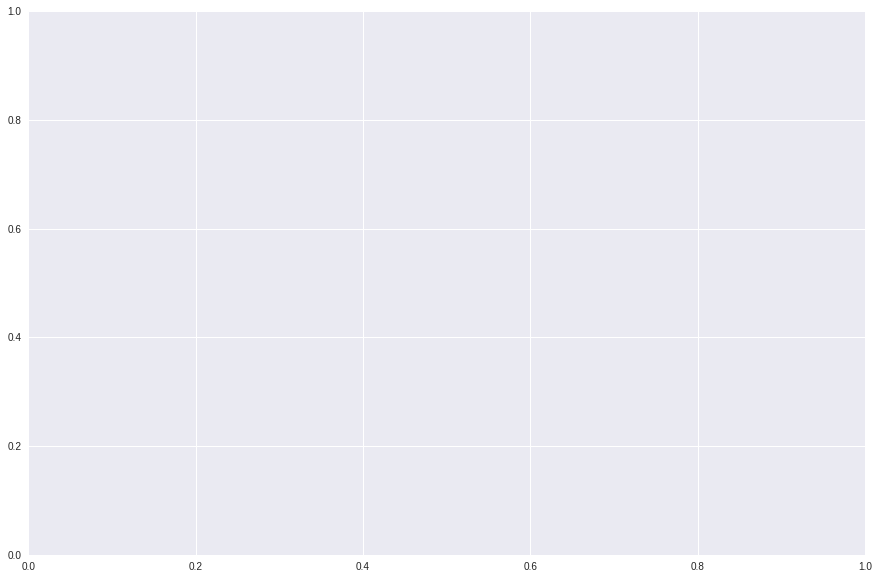

In [14]:
#stratified 10 folds
from sklearn.model_selection import StratifiedKFold

#df_task2.info()
#del df_task2['popularity']

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# Load the diabetes dataset
#diabetes = datasets.load_diabetes()


# Use only one feature
#diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = df_task2[:-20]
diabetes_X_test = df_task2[-20:]

# Split the targets into training/testing sets
diabetes_y_train = df_task2.shares[:-20]
diabetes_y_test = df_task2.shares[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, regr.predict(diabetes_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Modeling and Evaluation 4
Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

John
* For Regression just compare attributes selected which are significantly
* For Classification determine accuracy, etc...

## Modeling and Evaluation 5
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

John

## Modeling and Evaluation 6
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

John

## Deployment
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

Scott

## Exceptional Work

You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

Scott

Possible Analysis:

Deep Learning

Neaural Network